In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

pd.set_option('display.max_rows', 500)

In [2]:
data = pd.read_csv("ufc_clean.csv")
data = data.set_index(pd.DatetimeIndex(data['Date']))
data.drop(['Date', 'Promotion'], axis=1, inplace=True)
data.head()

,Event,Venue,City,Attendance,Gate,Buyrate
Date,,,,,,
1993-11-12,UFC 1: The Beginning,McNichols Sports Arena,"Denver, Colorado",7800.0,NaN,86000.0
1994-03-11,UFC 2: No Way Out,Mammoth Gardens,"Denver, Colorado",2000.0,NaN,300000.0
1994-09-09,UFC 3: The American Dream,Grady Cole Center,"Charlotte, North Carolina",3000.0,NaN,90000.0
1994-12-16,UFC 4: Revenge of the Warriors,Expo Square Pavilion,"Tulsa, Oklahoma",5857.0,NaN,120000.0
1995-04-07,UFC 5: Gracie vs. Shamrock 2,Independence Arena,"Charlotte, North Carolina",6000.0,NaN,260000.0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 438 entries, 1993-11-12 to 2018-12-29
Data columns (total 6 columns):
Event         438 non-null object
Venue         438 non-null object
City          438 non-null object
Attendance    392 non-null float64
Gate          280 non-null float64
Buyrate       190 non-null float64
dtypes: float64(3), object(3)
memory usage: 24.0+ KB


## Feature Extraction

### Extract Event and Title

In [4]:
def extract_title(event):
    if ': ' in event:
        event_name, title_name = event.split(': ', maxsplit=1)
        return title_name
    else:
        return np.nan

def extract_event(event):
    if ': ' in event:
        event_name, title_name = event.split(': ', maxsplit=1)
        return event_name
    else:
        return event  

In [5]:
titles = data['Event'].apply(extract_title)
data.insert(1, 'Title', titles)
data['Event'] = data['Event'].apply(extract_event)

In [6]:
data.head()

,Event,Title,Venue,City,Attendance,Gate,Buyrate
Date,,,,,,,
1993-11-12,UFC 1,The Beginning,McNichols Sports Arena,"Denver, Colorado",7800.0,NaN,86000.0
1994-03-11,UFC 2,No Way Out,Mammoth Gardens,"Denver, Colorado",2000.0,NaN,300000.0
1994-09-09,UFC 3,The American Dream,Grady Cole Center,"Charlotte, North Carolina",3000.0,NaN,90000.0
1994-12-16,UFC 4,Revenge of the Warriors,Expo Square Pavilion,"Tulsa, Oklahoma",5857.0,NaN,120000.0
1995-04-07,UFC 5,Gracie vs. Shamrock 2,Independence Arena,"Charlotte, North Carolina",6000.0,NaN,260000.0


### Extract fighter names from Title

In [7]:
fighter2_p = re.compile("(.+) [Finale|[0-9]]*")

In [8]:
def extract_fighter1(title):
    if ' vs ' in str(title):
        title = title.replace(' vs ', ' vs. ')
    if ' vs. ' in str(title):
        fighter1 = title.split(' vs. ')[0]
        return fighter1
    
def _drop_roman_nums(string):
    if string.endswith(' II'):
        return string.replace(' II', '')
    elif string.endswith(' III'):
        return string.replace(' III', '')
    else:
        return string
    
def extract_fighter2(title):
    if ' vs ' in str(title):
        title = title.replace(' vs ', ' vs. ')
    if ' vs. ' in str(title):
        fighter2 = title.split(' vs. ')[1]
        if fighter2_p.match(fighter2):
            return _drop_roman_nums(fighter2_p.findall(fighter2)[0])
        return _drop_roman_nums(fighter2)

In [9]:
example = "Velasquez vs. dos Santos III"
print(extract_fighter1(example))
print(extract_fighter2(example))

Velasquez
dos Santos


In [10]:
fighter1 = data['Title'].apply(extract_fighter1)
data.insert(3, "Fighter_1", fighter1)

fighter2 = data['Title'].apply(extract_fighter2)
data.insert(4, "Fighter_2", fighter2)

In [11]:
data.iloc[420:430]

,Event,Title,Venue,Fighter_1,Fighter_2,City,Attendance,Gate,Buyrate
Date,,,,,,,,,
2018-07-22,UFC Fight Night,Shogun vs. Smith,Barclaycard Arena,Shogun,Smith,"Hamburg, Germany",7798.0,750000.0,NaN
2018-07-28,UFC on Fox,Alvarez vs. Poirier 2,Scotiabank Saddledome,Alvarez,Poirier,"Calgary, Alberta, Canada",10603.0,NaN,NaN
2018-08-04,UFC 227,Dillashaw vs. Garbrandt 2,Staples Center,Dillashaw,Garbrandt,"Los Angeles, California",17794.0,2850000.0,300000.0
2018-08-25,UFC Fight Night,Gaethje vs. Vick,Pinnacle Bank Arena,Gaethje,Vick,"Lincoln, Nebraska",6409.0,478337.0,NaN
2018-09-08,UFC 228,Woodley vs. Till,American Airlines Center,Woodley,Till,"Dallas, Texas",14073.0,1700000.0,NaN
2018-09-15,UFC Fight Night,Hunt vs. Oliynyk,Olimpiyskiy Stadium,Hunt,Oliynyk,"Moscow, Russia",NaN,NaN,NaN
2018-09-22,UFC Fight Night,Manuwa vs. Santos,Ginásio do Ibirapuera,Manuwa,Santos,"São Paulo, Brazil",NaN,NaN,NaN
2018-10-06,UFC 229,Khabib vs. McGregor,T-Mobile Arena,Khabib,McGregor,"Paradise, Nevada",NaN,NaN,NaN
2018-10-27,UFC Fight Night,Volkan vs. Smith,Moncton Events Centre,Volkan,Smith,"Moncton, New Brunswick, Canada",NaN,NaN,NaN


In [12]:
data = data.set_value('2006-10-10', 'Fighter_2', 'Shamrock')

/home/will/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  """Entry point for launching an IPython kernel.


### Extract Rematches

In [13]:
def extract_rematch(title):
    title = str(title)
    if ('2' in title) or ('3' in title) or ('II' in title) or ('III' in title):
        return 1
    else:
        return 0

In [14]:
rematch = data['Title'].apply(extract_rematch)
data.insert(5, "Rematch", rematch)
data.iloc[390:400]

,Event,Title,Venue,Fighter_1,Fighter_2,Rematch,City,Attendance,Gate,Buyrate
Date,,,,,,,,,,
2017-11-04,UFC 217,Bisping vs. St-Pierre,Madison Square Garden,Bisping,St-Pierre,0,"New York City, New York",18201.0,6200000.0,875000.0
2017-11-11,UFC Fight Night,Poirier vs. Pettis,Ted Constant Convocation Center,Poirier,Pettis,0,"Norfolk, Virginia",8442.0,642070.0,NaN
2017-11-19,UFC Fight Night,Werdum vs. Tybura,Qudos Bank Arena,Werdum,Tybura,0,Sydney,10021.0,NaN,NaN
2017-11-25,UFC Fight Night,Bisping vs. Gastelum,Mercedes Benz Arena,Bisping,Gastelum,0,"Shanghai, China",15128.0,NaN,NaN
2017-12-01,The Ultimate Fighter,A New World Champion Finale,Park Theater,None,None,0,"Paradise, Nevada",NaN,NaN,NaN
2017-12-02,UFC 218,Holloway vs. Aldo 2,Little Caesars Arena,Holloway,Aldo,1,"Detroit, Michigan",17587.0,2000000.0,230000.0
2017-12-09,UFC Fight Night,Swanson vs. Ortega,Save Mart Center,Swanson,Ortega,0,"Fresno, California",7605.0,568290.0,NaN
2017-12-16,UFC on Fox,Lawler vs. dos Anjos,Bell MTS Place,Lawler,dos Anjos,0,"Winnipeg, Canada",8862.0,781359.0,NaN
2017-12-30,UFC 219,Cyborg vs. Holm,T-Mobile Arena,Cyborg,Holm,0,"Las Vegas, Nevada",13561.0,1760628.0,380000.0


### Extract Main Events

In [15]:
main_event_p = re.compile("UFC [0-9]+")
main_event = data['Event'].apply(lambda x: 1 if main_event_p.match(x) else 0)

In [16]:
data.insert(1, 'Main_Event', main_event)

In [17]:
data.iloc[420:430]

,Event,Main_Event,Title,Venue,Fighter_1,Fighter_2,Rematch,City,Attendance,Gate,Buyrate
Date,,,,,,,,,,,
2018-07-22,UFC Fight Night,0,Shogun vs. Smith,Barclaycard Arena,Shogun,Smith,0,"Hamburg, Germany",7798.0,750000.0,NaN
2018-07-28,UFC on Fox,0,Alvarez vs. Poirier 2,Scotiabank Saddledome,Alvarez,Poirier,1,"Calgary, Alberta, Canada",10603.0,NaN,NaN
2018-08-04,UFC 227,1,Dillashaw vs. Garbrandt 2,Staples Center,Dillashaw,Garbrandt,1,"Los Angeles, California",17794.0,2850000.0,300000.0
2018-08-25,UFC Fight Night,0,Gaethje vs. Vick,Pinnacle Bank Arena,Gaethje,Vick,0,"Lincoln, Nebraska",6409.0,478337.0,NaN
2018-09-08,UFC 228,1,Woodley vs. Till,American Airlines Center,Woodley,Till,0,"Dallas, Texas",14073.0,1700000.0,NaN
2018-09-15,UFC Fight Night,0,Hunt vs. Oliynyk,Olimpiyskiy Stadium,Hunt,Oliynyk,0,"Moscow, Russia",NaN,NaN,NaN
2018-09-22,UFC Fight Night,0,Manuwa vs. Santos,Ginásio do Ibirapuera,Manuwa,Santos,0,"São Paulo, Brazil",NaN,NaN,NaN
2018-10-06,UFC 229,1,Khabib vs. McGregor,T-Mobile Arena,Khabib,McGregor,0,"Paradise, Nevada",NaN,NaN,NaN
2018-10-27,UFC Fight Night,0,Volkan vs. Smith,Moncton Events Centre,Volkan,Smith,0,"Moncton, New Brunswick, Canada",NaN,NaN,NaN


# Buyrate Analysis of UFC Main Events

In [18]:
buys = data[~data['Buyrate'].isnull()] # Complete Buyrate info
ufc = buys[buys['Main_Event'] == 1] # Main events only
ufc_10y = ufc['2008':'2018']

In [19]:
ufc_10y.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 130 entries, 2008-01-19 to 2018-08-04
Data columns (total 11 columns):
Event         130 non-null object
Main_Event    130 non-null int64
Title         129 non-null object
Venue         130 non-null object
Fighter_1     115 non-null object
Fighter_2     115 non-null object
Rematch       130 non-null int64
City          130 non-null object
Attendance    130 non-null float64
Gate          106 non-null float64
Buyrate       130 non-null float64
dtypes: float64(3), int64(2), object(6)
memory usage: 12.2+ KB


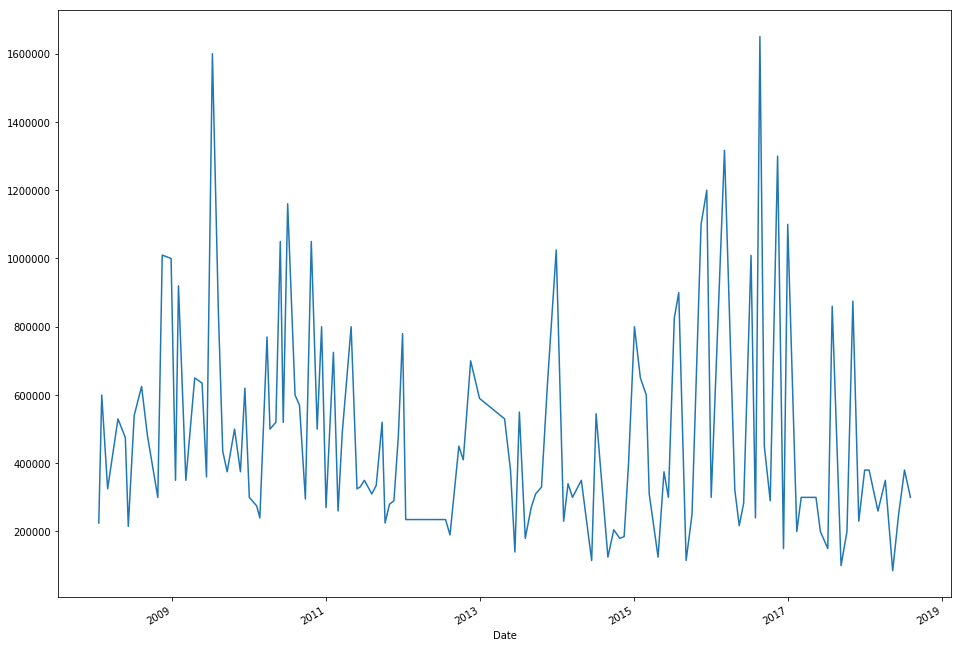

In [20]:
plt.figure(figsize=(16,12))
ufc_10y['Buyrate'].plot()

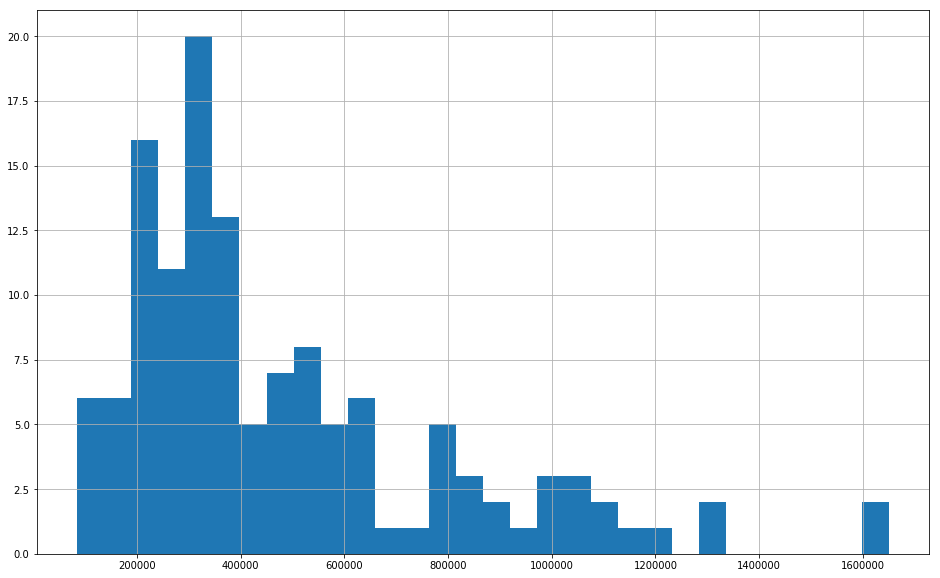

In [92]:
plt.figure(figsize=(16,10))
ufc_10y['Buyrate'].hist(bins=30)

In [26]:
fighter1 = ufc_10y.drop("Fighter_2", axis=1)
fighter1.insert(0, "Fighter", fighter1_df['Fighter_1'])

In [27]:
fighter2 = ufc_10y.drop("Fighter_1", axis=1)
fighter2.insert(0, "Fighter", fighter2_df['Fighter_2'])

In [28]:
fighters = pd.concat([fighter1_df, fighter2_df], sort=False)
fighters.drop(['Fighter_1', 'Fighter_2'], axis=1, inplace=True)
fighters.sort_index(inplace=True)

In [29]:
fighters.iloc[200:220]

,Fighter,Event,Main_Event,Title,Venue,Rematch,City,Attendance,Gate,Buyrate
Date,,,,,,,,,,
2016-04-23,Jones,UFC 197,1,Jones vs. Saint Preux,MGM Grand Garden Arena,0,"Las Vegas, Nevada",11352.0,2300000.0,322000.0
2016-04-23,Saint Preux,UFC 197,1,Jones vs. Saint Preux,MGM Grand Garden Arena,0,"Las Vegas, Nevada",11352.0,2300000.0,322000.0
2016-05-14,Werdum,UFC 198,1,Werdum vs. Miocic,Arena da Baixada,0,"Curitiba, Brazil",45207.0,NaN,217000.0
2016-05-14,Miocic,UFC 198,1,Werdum vs. Miocic,Arena da Baixada,0,"Curitiba, Brazil",45207.0,NaN,217000.0
2016-06-04,Rockhold,UFC 199,1,Rockhold vs. Bisping 2,The Forum,1,"Inglewood, California",15587.0,2168675.0,283000.0
2016-06-04,Bisping,UFC 199,1,Rockhold vs. Bisping 2,The Forum,1,"Inglewood, California",15587.0,2168675.0,283000.0
2016-07-09,Nunes,UFC 200,1,Tate vs. Nunes,T-Mobile Arena,0,"Las Vegas, Nevada",18202.0,10746248.0,1009000.0
2016-07-09,Tate,UFC 200,1,Tate vs. Nunes,T-Mobile Arena,0,"Las Vegas, Nevada",18202.0,10746248.0,1009000.0
2016-07-30,Lawler,UFC 201,1,Lawler vs. Woodley,Philips Arena,0,"Atlanta, Georgia",10240.0,1070000.0,240000.0


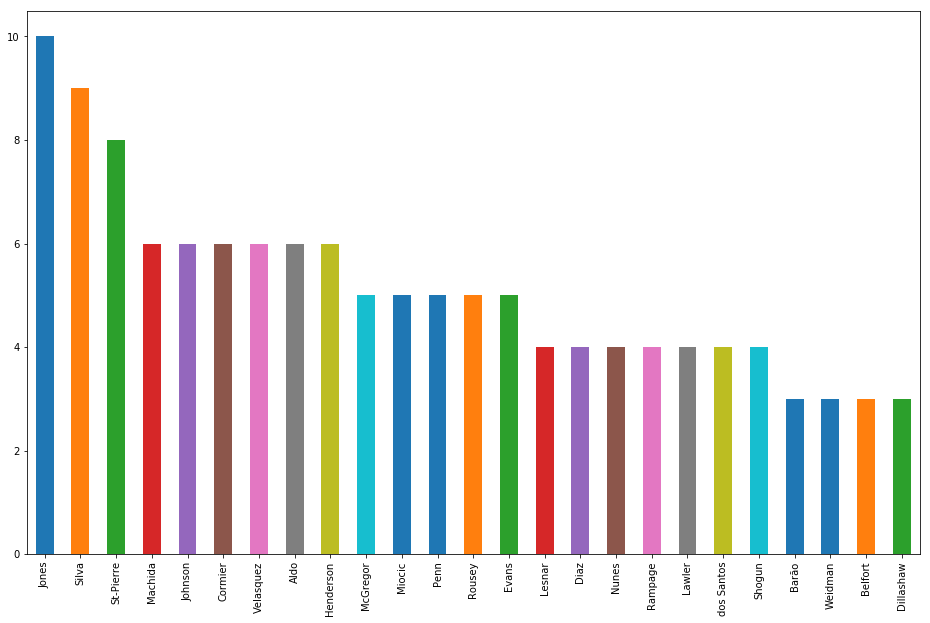

In [35]:
plt.figure(figsize=(16,10))
fighters['Fighter'].value_counts()[:25].plot('bar')

In [55]:
buyrates = fighters.groupby('Fighter')['Buyrate'].mean()

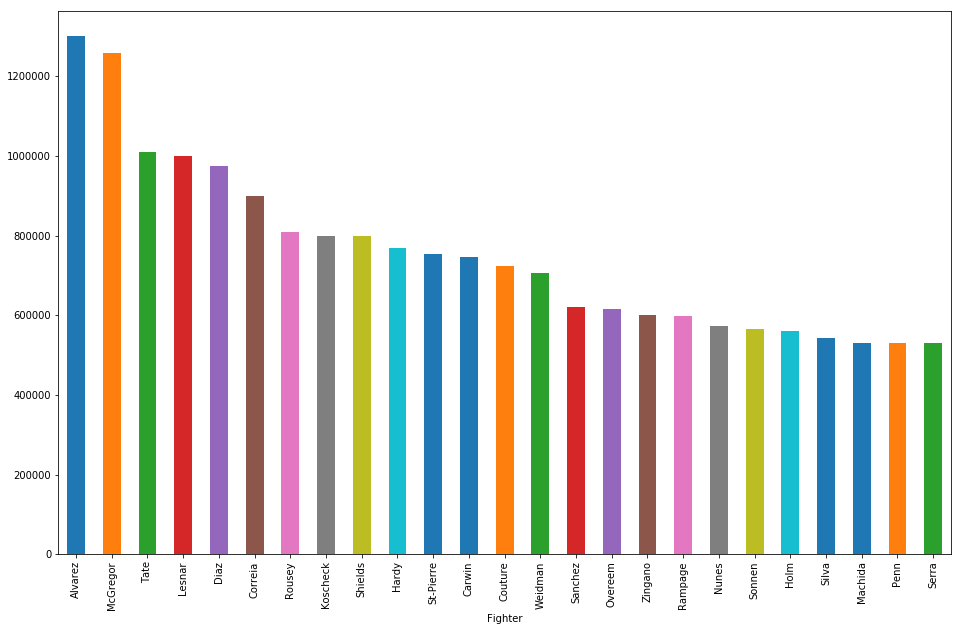

In [58]:
plt.figure(figsize=(16,10))
buyrates.sort_values(ascending=False)[:25].plot('bar')